In [3]:
import os

import warnings

import vizdoom

import cv2
import numpy as np
from collections import deque

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Ignore Warnings

In [4]:
tf.get_logger().setLevel("ERROR")

# Environment Setup And Preprocessing

In [2]:
K = keras.backend

In [3]:
def create_env():
    env = vizdoom.DoomGame()
    env.load_config("deadly_corridor.cfg")
    env.init()
    
    return env

In [280]:
def data_loader(number_of_videos=10, random=True, index=0):
    path = os.path.join("vizdoom_rgb_dataset")
    
    if random == True:
        random_video_index = np.random.randint(number_of_videos)
    else:
        random_video_index = index
    
    states = np.load(path + "//states{}.npy".format(random_video_index), allow_pickle=True)
    actions = np.load(path + "//actions{}.npy".format(random_video_index), allow_pickle=True)
    rewards = np.load(path + "//rewards{}.npy".format(random_video_index), allow_pickle=True)
    next_states = np.load(path + "//n_states{}.npy".format(random_video_index), allow_pickle=True)
    dones = np.load(path + "//dones{}.npy".format(random_video_index), allow_pickle=True)
    
    return states, actions, rewards, next_states, dones

In [5]:
def preprocess_frame(frame):
    
    cropped_image = frame[:-35].astype(np.uint8)
    resized_image = Image.fromarray(cropped_image).resize((64, 64))
    scaled_image = np.array(resized_image) / 255.
    
    return scaled_image

In [6]:
input_shape = (64, 64, 3)

# Custom Layers

In [152]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [8]:
class SE_block(keras.layers.Layer):
    def __init__(self, filters, activation="relu", **kwargs):
        super().__init__()
        self.activation = keras.activations.get(activation)
        
        self.relu_layer = [
            keras.layers.Dense(filters, activation="relu")
        ]
        
        self.SEblock = [
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(filters, activation="relu"),
            keras.layers.Dense(filters, activation="sigmoid")
        ]
        
    def call(self, inputs):    
        SE_Z = inputs
        
        for layer in self.SEblock:
            SE_Z = layer(SE_Z)
            
        print(SE_Z.shape)
        
        inputs = keras.layers.Flatten()(inputs)
        for layer in self.relu_layer:
            inputs = layer(inputs)
        print(inputs.shape)
            
        product = keras.layers.Multiply()(inputs, SE_Z)
        
        return product

In [9]:
class ResidualUnitTranspose(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2DTranspose(filters, kernel_size=3, strides=strides,
                               padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2DTranspose(filters, kernel_size=3, strides=1,
                               padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2DTranspose(filters, kernel_size=1, strides=strides,
                                   padding="same", use_bias=False),
                keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [10]:
class SumLayer(keras.layers.Layer):
    def call(self, inputs):
        in_a, in_b = inputs
        return in_a + in_b

# Variational Autoencoder

In [153]:
codings_size = 256

encoder_inputs = keras.layers.Input(shape=input_shape)
z = keras.layers.Conv2D(16, kernel_size=3, strides=1, 
                        padding="same", use_bias=False, name="first_encoder_conv2d")(encoder_inputs)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Activation("relu")(z)

#z = ResidualUnit(32, strides=2)(z)
#z = ResidualUnit(64, strides=2)(z)

z = keras.layers.Conv2D(32, kernel_size=3, strides=2, 
                        padding="same", use_bias=False, name="second_encoder_conv2d")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Activation("relu")(z)

z = keras.layers.Conv2D(64, kernel_size=3, strides=2, 
                        padding="same", use_bias=False, name="output_encoder_conv2d")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Activation("relu")(z)

z = keras.layers.Flatten()(z)

codings_mean = keras.layers.Dense(codings_size, activation="relu")(z)
codings_log_var = keras.layers.Dense(codings_size, activation="relu")(z)
codings = Sampling()([codings_mean, codings_log_var])

encoder = keras.Model(
    inputs=[encoder_inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=(codings_size,))
x = keras.layers.Dense(16 * 16 * 64, activation="relu")(decoder_inputs)
x = keras.layers.Reshape((16, 16, 64))(x)

'''x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, 
                                 padding="same", use_bias=False, name="first_decoder_transpose2d")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, 
                                 padding="same", use_bias=False, name="second_decoder_transpose2d")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)'''

x = ResidualUnitTranspose(32, strides=2)(x)
x = ResidualUnitTranspose(16, strides=2)(x)

x = keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1, 
                                 padding="same", use_bias=False, name="output_decoder_transpose2d")(x)
x = keras.layers.BatchNormalization()(x)
decoder_outputs = keras.layers.Activation("sigmoid")(x)

decoder = keras.Model(
    inputs=[decoder_inputs], outputs=[decoder_outputs])

_, _, codings = encoder(encoder_inputs)
reconstructions = decoder(codings)
autoencoder = keras.Model(inputs=[encoder_inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

autoencoder.add_loss(K.mean(latent_loss) / 64 * 64 * 3)
autoencoder.compile(loss="binary_crossentropy", optimizer="adam")

def pretrain_the_autoencoder(number_of_epochs=1000):
    for epoch in range(number_of_epochs):
        print("Epoch: ", epoch + 1)
        
        replay_buffer = deque(maxlen=5000)
        batch_size = 128

        states, actions, rewards, next_states = data_loader()
        random_frame_index = np.random.randint(states.shape[0])

        state = states[random_frame_index][np.newaxis]
        replay_buffer.append(state)

        plt.imshow(state[0])
        plt.axis("off")
        plt.show()
        
        if epoch > 10:
            
            indices = np.random.randint(len(replay_buffer), size=batch_size)
            batch = [replay_buffer[index] for index in indices]
            
            '''if epoch < 50:
                decoder.trainable = False
            else:
                decoder.trainable = True'''
            
            autoencoder.train_on_batch(batch, batch)
            predictions = autoencoder(batch)
                
            plt.imshow(batch[0][0])
            plt.title("Ground Truth")
            plt.axis("off")
            plt.show()
            
            plt.imshow(predictions.numpy()[0])
            plt.title("Predictions")
            plt.axis("off")
            plt.show()
            
            loss = keras.losses.BinaryCrossentropy(from_logits=False)(batch, predictions)
            print("Loss: ", loss)

#pretrain_the_autoencoder()

# Reinforcement Learning Model

In [172]:
model_input = keras.layers.Input(shape=(64, 64, 3))
i = keras.layers.Conv2D(16, kernel_size=3, strides=1, 
                        padding="same", use_bias=False, name="first_encoder_conv2d")(model_input)
i = keras.layers.BatchNormalization()(i)
i = keras.layers.Activation("relu")(i)

i = keras.layers.Conv2D(32, kernel_size=3, strides=2, 
                        padding="same", use_bias=False, name="second_encoder_conv2d")(i)
i = keras.layers.BatchNormalization()(i)
i = keras.layers.Activation("relu")(i)

i = keras.layers.Conv2D(64, kernel_size=3, strides=2, 
                        padding="same", use_bias=False, name="output_encoder_conv2d")(i)
i = keras.layers.BatchNormalization()(i)
i = keras.layers.Activation("relu")(i)

#i = keras.layers.GlobalAveragePooling2D()(i)
i = keras.layers.Flatten()(i)

codings_mean = keras.layers.Dense(256, activation="relu")(i)
codings_log_var = keras.layers.Dense(256, activation="relu")(i)
codings = Sampling()([codings_mean, codings_log_var])

i = keras.layers.Dense(128, activation="relu")(codings)
i = keras.layers.Dense(32, activation="sigmoid")(i)

model_output = keras.layers.Dense(7)(i)

model = keras.Model(inputs=[model_input], outputs=[model_output])

encoder = keras.Model(inputs=[model_input], outputs=[codings_mean, codings_log_var, codings])

_, _, codings = encoder(model_input)
reconstructions = decoder(codings)

autoencoder = keras.Model(inputs=[model_input], outputs=[reconstructions])
autoencoder.compile(loss="binary_crossentropy", optimizer="adam")

In [173]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        random_arg = np.random.randint(7)
        random_action = np.zeros((7,), dtype=np.float32)
        random_action[random_arg] = 1
        return list(random_action)
    else:
        Q_values = model.predict(state[np.newaxis])
        max_action = np.argmax(Q_values[0])
        action = np.zeros((7,), dtype=np.float32)
        action[max_action] = 1
        return list(action)

In [175]:
replay_buffer = deque(maxlen=10000)
#per = PER(10000)
batch_size = 128
discount_factor = 0.95
#clipnorm=1.0
optimizer = keras.optimizers.Adam(clipnorm=1.0, lr=1e-3)
loss_fn = keras.losses.mean_squared_error

#target = keras.models.load_model("DQFD.h5")
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [176]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [177]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = target.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = actions
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values *  mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Episode:  1
-0.002547363281249996
Highest score:  0
Episode:  2
-0.010477264404296874
Highest score:  0
Episode:  3
The end of the best episode ever: 


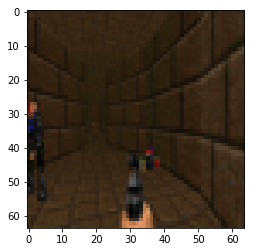

0.013033264160156254
Highest score:  0.013033264160156254
Episode:  4
-0.01597560119628906
Highest score:  0.013033264160156254
Episode:  5
0.01150503540039064
Highest score:  0.013033264160156254
Episode:  6
The end of the best episode ever: 


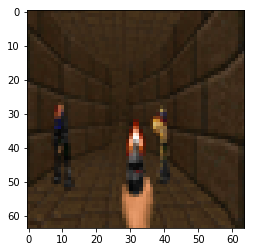

0.01358583068847656
Highest score:  0.01358583068847656
Episode:  7
0.006637527465820329
Highest score:  0.01358583068847656
Episode:  8
0.0038374938964843733
Highest score:  0.01358583068847656
Episode:  9
The end of the best episode ever: 


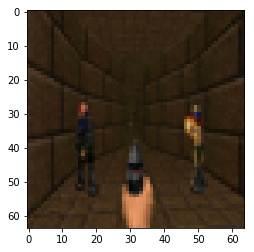

0.033019241333007814
Highest score:  0.033019241333007814
Episode:  10
0.011194473266601557
Highest score:  0.033019241333007814
Episode:  11
-0.015911956787109372
Highest score:  0.033019241333007814
Episode:  12
The end of the best episode ever: 


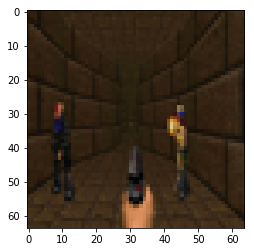

0.039276763916015624
Highest score:  0.039276763916015624
Episode:  13
-0.009500396728515615
Highest score:  0.039276763916015624
Episode:  14
-0.005761932373046878
Highest score:  0.039276763916015624
Episode:  15
0.003995773315429681
Highest score:  0.039276763916015624
Episode:  16
-0.004084274291992179
Highest score:  0.039276763916015624
Episode:  17
0.006671508789062498
Highest score:  0.039276763916015624
Episode:  18
0.0017171783447265622
Highest score:  0.039276763916015624
Episode:  19
-0.015299835205078122
Highest score:  0.039276763916015624
Episode:  20
-0.007920959472656253
Highest score:  0.039276763916015624
Episode:  21
-0.01442643737792969
Highest score:  0.039276763916015624
Episode:  22
0.00042160034179688024
Highest score:  0.039276763916015624
Episode:  23
0.0014630126953125032
Highest score:  0.039276763916015624
Episode:  24
-0.002260055541992183
Highest score:  0.039276763916015624
Episode:  25
-0.015218841552734374
Highest score:  0.039276763916015624
Episode:

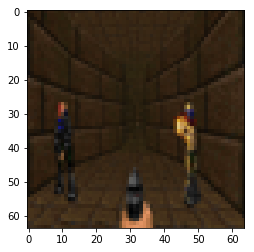

0.04692424011230469
Highest score:  0.04692424011230469
Episode:  76
0.009844528198242188
Highest score:  0.04692424011230469
Episode:  77
0.027155731201171894
Highest score:  0.04692424011230469
Episode:  78
-0.015162307739257804
Highest score:  0.04692424011230469
Episode:  79
-0.011428634643554675
Highest score:  0.04692424011230469
Episode:  80
0.03675677490234375
Highest score:  0.04692424011230469
Episode:  81
-0.01400531005859375
Highest score:  0.04692424011230469
Episode:  82
-0.015936599731445313
Highest score:  0.04692424011230469
Episode:  83
-0.015435180664062503
Highest score:  0.04692424011230469
Episode:  84
-0.010337020874023436
Highest score:  0.04692424011230469
Episode:  85
The end of the best episode ever: 


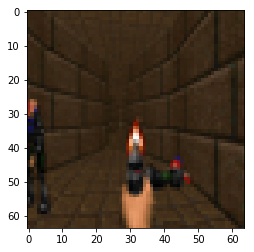

0.04959252929687501
Highest score:  0.04959252929687501
Episode:  86
-0.008467193603515622
Highest score:  0.04959252929687501
Episode:  87
0.024191665649414062
Highest score:  0.04959252929687501
Episode:  88
0.02720904541015625
Highest score:  0.04959252929687501
Episode:  89
0.01488951110839844
Highest score:  0.04959252929687501
Episode:  90
-0.013912506103515626
Highest score:  0.04959252929687501
Episode:  91
-0.013318679809570322
Highest score:  0.04959252929687501
Episode:  92
-0.015957427978515633
Highest score:  0.04959252929687501
Episode:  93
-0.015975631713867188
Highest score:  0.04959252929687501
Episode:  94
-0.015992248535156246
Highest score:  0.04959252929687501
Episode:  95
-0.007963836669921873
Highest score:  0.04959252929687501
Episode:  96
0.016869995117187498
Highest score:  0.04959252929687501
Episode:  97
0.0050335845947265655
Highest score:  0.04959252929687501
Episode:  98
-0.015971038818359373
Highest score:  0.04959252929687501
Episode:  99
0.004344924926

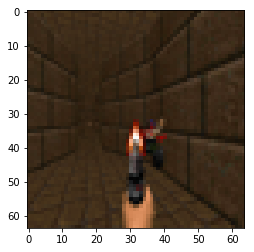

0.05192070007324219
Highest score:  0.05192070007324219
Episode:  128
-0.0014015350341796897
Highest score:  0.05192070007324219
Episode:  129
0.010509750366210942
Highest score:  0.05192070007324219
Episode:  130
0.014885055541992188
Highest score:  0.05192070007324219
Episode:  131
-0.0047214508056640575
Highest score:  0.05192070007324219
Episode:  132
0.0029181213378906244
Highest score:  0.05192070007324219
Episode:  133
0.02516352844238283
Highest score:  0.05192070007324219
Episode:  134
-0.0157591552734375
Highest score:  0.05192070007324219
Episode:  135
-0.011122711181640623
Highest score:  0.05192070007324219
Episode:  136
-0.005328292846679682
Highest score:  0.05192070007324219
Episode:  137
-0.0002250213623046882
Highest score:  0.05192070007324219
Episode:  138
-0.010000198364257817
Highest score:  0.05192070007324219
Episode:  139
-0.015967697143554685
Highest score:  0.05192070007324219
Episode:  140
0.0003455352783203142
Highest score:  0.05192070007324219
Episode:  1

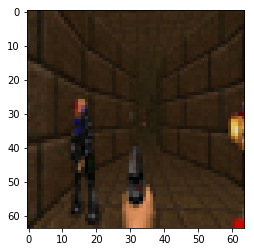

0.07182109069824219
Highest score:  0.07182109069824219
Episode:  182
The end of the best episode ever: 


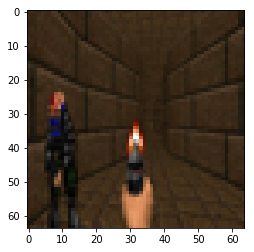

0.09576956176757812
Highest score:  0.09576956176757812
Episode:  183
0.05336105346679687
Highest score:  0.09576956176757812
Episode:  184
The end of the best episode ever: 


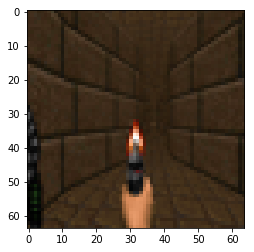

0.11661601257324218
Highest score:  0.11661601257324218
Episode:  185
0.02145188903808594
Highest score:  0.11661601257324218
Episode:  186
-0.008425323486328122
Highest score:  0.11661601257324218
Episode:  187
-0.015195861816406248
Highest score:  0.11661601257324218
Episode:  188
0.011206268310546871
Highest score:  0.11661601257324218
Episode:  189
0.037120208740234396
Highest score:  0.11661601257324218
Episode:  190
The end of the best episode ever: 


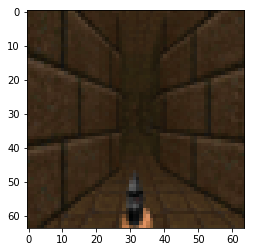

0.18007856750488274
Highest score:  0.18007856750488274
Episode:  191
The end of the best episode ever: 


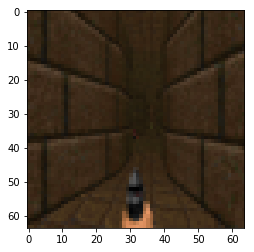

0.1991445465087891
Highest score:  0.1991445465087891
Episode:  192
0.06585408020019533
Highest score:  0.1991445465087891
Episode:  193
0.1256842346191406
Highest score:  0.1991445465087891
Episode:  194
0.10780407714843748
Highest score:  0.1991445465087891
Episode:  195
The end of the best episode ever: 


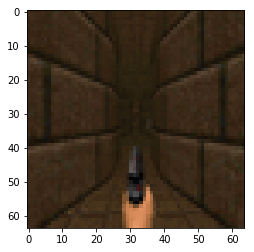

0.20837973022460932
Highest score:  0.20837973022460932
Episode:  196
0.03124067687988282
Highest score:  0.20837973022460932
Episode:  197
0.11044132995605466
Highest score:  0.20837973022460932
Episode:  198
0.1093842468261719
Highest score:  0.20837973022460932
Episode:  199
0.05431752014160157
Highest score:  0.20837973022460932
Episode:  200
0.06147920227050779
Highest score:  0.20837973022460932
Episode:  201
-0.015492095947265623
Highest score:  0.20837973022460932
Episode:  202
-0.01522096252441406
Highest score:  0.20837973022460932
Episode:  203
-0.015993209838867182
Highest score:  0.20837973022460932
Episode:  204
0.0013667449951171875
Highest score:  0.20837973022460932
Episode:  205
-0.003495361328125001
Highest score:  0.20837973022460932
Episode:  206
-0.015990417480468748
Highest score:  0.20837973022460932
Episode:  207
0.01759776306152344
Highest score:  0.20837973022460932
Episode:  208
-0.01406396484375
Highest score:  0.20837973022460932
Episode:  209
-0.005931060

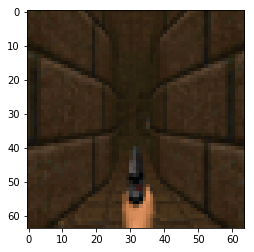

0.21666659545898437
Highest score:  0.21666659545898437
Episode:  232
0.12160365295410158
Highest score:  0.21666659545898437
Episode:  233
0.18452404785156257
Highest score:  0.21666659545898437
Episode:  234
0.137959228515625
Highest score:  0.21666659545898437
Episode:  235
0.16249076843261717
Highest score:  0.21666659545898437
Episode:  236
0.07911412048339844
Highest score:  0.21666659545898437
Episode:  237
0.005348083496093748
Highest score:  0.21666659545898437
Episode:  238
0.11277749633789062
Highest score:  0.21666659545898437
Episode:  239
0.08229981994628904
Highest score:  0.21666659545898437
Episode:  240
0.039494812011718755
Highest score:  0.21666659545898437
Episode:  241
0.0896566162109375
Highest score:  0.21666659545898437
Episode:  242
0.004581939697265627
Highest score:  0.21666659545898437
Episode:  243
-0.015996444702148435
Highest score:  0.21666659545898437
Episode:  244
-0.012375244140624993
Highest score:  0.21666659545898437
Episode:  245
-0.0157215881347

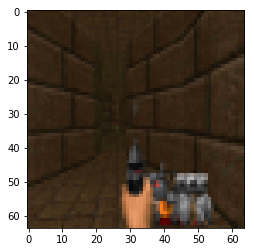

0.5444049224853514
Highest score:  0.5444049224853514
Episode:  273
0.4188618011474609
Highest score:  0.5444049224853514
Episode:  274
0.25019093322753905
Highest score:  0.5444049224853514
Episode:  275
0.04803746032714843
Highest score:  0.5444049224853514
Episode:  276
0.13403099060058596
Highest score:  0.5444049224853514
Episode:  277
0.0944194030761719
Highest score:  0.5444049224853514
Episode:  278
0.0823574981689453
Highest score:  0.5444049224853514
Episode:  279
0.041041198730468756
Highest score:  0.5444049224853514
Episode:  280
0.08967793273925782
Highest score:  0.5444049224853514
Episode:  281
0.052797149658203125
Highest score:  0.5444049224853514
Episode:  282
0.044360244750976545
Highest score:  0.5444049224853514
Episode:  283
-0.010118347167968746
Highest score:  0.5444049224853514
Episode:  284
0.006140335083007813
Highest score:  0.5444049224853514
Episode:  285
0.016538040161132812
Highest score:  0.5444049224853514
Episode:  286
-0.0026328887939453135
Highest 

Episode:  390
-0.015998657226562508
Highest score:  0.5444049224853514
Episode:  391
0.0024703521728515576
Highest score:  0.5444049224853514
Episode:  392
0.003402008056640629
Highest score:  0.5444049224853514
Episode:  393
-0.00832455444335939
Highest score:  0.5444049224853514
Episode:  394
-0.013271621704101564
Highest score:  0.5444049224853514
Episode:  395
-0.015987075805664063
Highest score:  0.5444049224853514
Episode:  396
-0.012365829467773443
Highest score:  0.5444049224853514
Episode:  397
-0.003663345336914066
Highest score:  0.5444049224853514
Episode:  398
-0.0004249267578125007
Highest score:  0.5444049224853514
Episode:  399
0.0012149200439453148
Highest score:  0.5444049224853514
Episode:  400
-0.014604995727539065
Highest score:  0.5444049224853514
Episode:  401
-0.015962738037109386
Highest score:  0.5444049224853514
Episode:  402
-0.014759658813476564
Highest score:  0.5444049224853514
Episode:  403
0.05604988098144526
Highest score:  0.5444049224853514
Episode: 

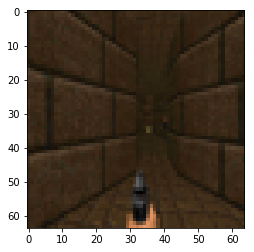

0.5986039276123046
Highest score:  0.5986039276123046
Episode:  475
0.234138916015625
Highest score:  0.5986039276123046
Episode:  476
0.17933525085449217
Highest score:  0.5986039276123046
Episode:  477
0.30674023437500003
Highest score:  0.5986039276123046
Episode:  478
0.1532411193847656
Highest score:  0.5986039276123046
Episode:  479
0.3132541198730469
Highest score:  0.5986039276123046
Episode:  480
0.18705773925781252
Highest score:  0.5986039276123046
Episode:  481
0.32658705139160155
Highest score:  0.5986039276123046
Episode:  482
0.19394958496093748
Highest score:  0.5986039276123046
Episode:  483
0.2503596649169922
Highest score:  0.5986039276123046
Episode:  484
0.44454129028320316
Highest score:  0.5986039276123046
Episode:  485
0.1361875
Highest score:  0.5986039276123046
Episode:  486
0.1800369415283203
Highest score:  0.5986039276123046
Episode:  487
0.4860635375976563
Highest score:  0.5986039276123046
Episode:  488
0.3028273162841797
Highest score:  0.598603927612304

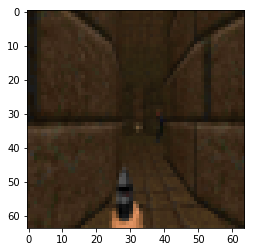

0.6865043792724611
Highest score:  0.6865043792724611
Episode:  537
0.3034389038085938
Highest score:  0.6865043792724611
Episode:  538
-0.01597566223144531
Highest score:  0.6865043792724611
Episode:  539
-0.012406234741210932
Highest score:  0.6865043792724611
Episode:  540
-0.015975585937499998
Highest score:  0.6865043792724611
Episode:  541
-0.015976348876953123
Highest score:  0.6865043792724611
Episode:  542
-0.015976348876953123
Highest score:  0.6865043792724611
Episode:  543
-0.01599861145019531
Highest score:  0.6865043792724611
Episode:  544
-0.01597906494140625
Highest score:  0.6865043792724611
Episode:  545
-0.01597636413574219
Highest score:  0.6865043792724611
Episode:  546
-0.015976348876953123
Highest score:  0.6865043792724611
Episode:  547
-0.015979049682617187
Highest score:  0.6865043792724611
Episode:  548
-0.015983535766601567
Highest score:  0.6865043792724611
Episode:  549
-0.015977554321289066
Highest score:  0.6865043792724611
Episode:  550
-0.0159839477539

In [178]:
env = create_env()
highest_score = 0

for episode in range(600):
    print("Episode: ", episode+1)

    env.new_episode()
    total_rewards = 0

    s = env.get_state()
    s = np.stack(s.screen_buffer, axis=-1)
    s = preprocess_frame(s)
    #s = encoder(s[np.newaxis])[2][0]
    
    for step in range(1000):
        epsilon = max(1 - episode / 500, 0.01)
        a = epsilon_greedy_policy(s, epsilon)
        r = env.make_action(a) / 1000
        d = env.is_episode_finished()
        
        if d:
            ns = np.zeros((64, 64, 3), dtype=np.int)
            #ns = encoder(ns[np.newaxis])[2][0]
            replay_buffer.append([s, a, r, ns, d])
            break

        else:
            ns = np.stack(env.get_state().screen_buffer, axis=-1)
            ns = preprocess_frame(ns)
            #ns = encoder(ns[np.newaxis])[2][0]
            replay_buffer.append([s, a, r, ns, d])
            s = ns

        total_rewards += r

    if total_rewards > highest_score:
        #model.save("GUD_SHOOTER.h5")
        highest_score = total_rewards
        
        print("The end of the best episode ever: ")
        plt.imshow(replay_buffer[-1][0])
        plt.show()

    print(total_rewards)
    print("Highest score: ", highest_score)
    
    if episode >= 50:
        training_step(batch_size)

    if episode % 200 == 0:
        target.set_weights(model.get_weights())

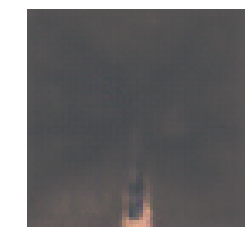

In [83]:
artificial_codings = K.random_normal(shape=(1, 256))
output_image = decoder(artificial_codings)

plt.imshow(output_image[0])
plt.axis("off")
plt.show()

# Create MP4 Files of the Dataset to Visualize the Data

In [185]:
for i in range(10):
    video = data_loader(random=False, index=i)[0] * 255
    output_mp3 = cv2.VideoWriter("videos//states{}.mp4".format(i), 0x7634706d, 20, (64, 64))
    
    for i in range(len(video)):
        output_mp3.write(cv2.cvtColor(video[i].astype(np.uint8), cv2.COLOR_BGR2RGB))
    output_mp3.release()

# Supervised Curiosity Learning Sample

In [234]:
feature_extraction_model = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=3, strides=2, activation="relu", input_shape=(64, 64, 3)),
    keras.layers.Conv2D(32, kernel_size=3, strides=2, activation="relu"),
    keras.layers.Conv2D(32, kernel_size=3, strides=2, activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(256)
])

feature_embedding_shape = 256

action_detection_model = keras.models.Sequential([
    keras.layers.Dense(256, input_shape=(feature_embedding_shape * 2,)),
    keras.layers.Dense(7)
])

next_state_prediction_model = keras.models.Sequential([
    keras.layers.Dense(128, input_shape=(feature_embedding_shape + 7,)),
    keras.layers.Dense(feature_embedding_shape)
])

In [255]:
class action_prediction_model(keras.Model):
    def __init__(self):
        super().__init__()
        self.feature_extractor = feature_extraction_model
        self.action_model = action_detection_model
    
    def call(self, inputs):
        #state_1: current state, state_2: next state
        state_1, state_2 = inputs
        state_1 = self.feature_extractor(state_1)
        state_2 = self.feature_extractor(state_2)
        print(state_1.shape)
        
        state_vector = tf.concat([state_1, state_2], axis=-1)
        predicted_action = self.action_model(state_vector)
        
        return predicted_action

In [256]:
class next_state_predictor_model(keras.Model):
    def __init__(self):
        super().__init__()
        self.feature_extractor = feature_extraction_model
        self.next_state_predictor = next_state_prediction_model
    
    def call(self, inputs):
        state_1, action = inputs
        
        inputs_ = self.feature_extractor(state_1)
        inputs_ = tf.concat([inputs_, action], axis=-1)
        print(inputs_.shape)
        
        outputs = self.next_state_predictor(inputs_)
        print(outputs.shape)
        
        return outputs        

In [261]:
test_state = np.zeros(shape=(1, 64, 64, 3))
test_next_state = np.ones(shape=(1, 64, 64, 3))

action_predictor = action_prediction_model()
print(action_predictor([test_state, test_next_state]))

(1, 256)
tf.Tensor(
[[-0.15162714 -0.05827254 -0.03979985  0.05214091 -0.0843223  -0.05461403
   0.03584426]], shape=(1, 7), dtype=float32)


In [262]:
test_action_state = np.ones(shape=(1, 64, 64, 3))
test_action = np.ones(shape=(1, 7))

next_state_pred = next_state_predictor_model()
print(next_state_pred([test_action_state, test_action]))

(1, 263)
(1, 256)
tf.Tensor(
[[-0.23063982  0.13341333  0.09020934 -0.08069547  0.237188    0.04494358
   0.03065793  0.10931475 -0.14343515 -0.11822055  0.20949411 -0.32555753
   0.00101046 -0.02301125 -0.05053193  0.17953885  0.0440312  -0.1378408
  -0.1091077  -0.13498732 -0.10387184 -0.0133045   0.01239692  0.33481055
  -0.26626417 -0.19564992  0.11203296  0.14035554 -0.08566244 -0.4699369
  -0.04219819  0.11494192 -0.30612743 -0.09097834  0.18325403 -0.26466608
  -0.04498255  0.05324456 -0.29637942 -0.13782048 -0.19423775  0.18237805
   0.14801548 -0.08913827 -0.25730097  0.25775966  0.06193064 -0.07496424
   0.02500206 -0.05557688 -0.2339797  -0.09301919  0.05801437  0.17258355
   0.00959927 -0.27180544 -0.14951745  0.09692381 -0.02189765 -0.02312829
  -0.044461    0.19992065 -0.07711004 -0.18290398 -0.01606783  0.3242609
  -0.16276255  0.0849217  -0.12821406 -0.34233952  0.06986137  0.07261638
  -0.16350053 -0.05620182 -0.15582533 -0.05474743  0.02655151  0.19725072
  -0.1229700

In [273]:
def next_state_prediction_loss(actual_next_state, predictions):
    temporal_difference = actual_next_state - predictions
    loss = 0.5 * tf.norm(tf.math.abs(temporal_difference), 2)
    
    return loss

In [286]:
def train_ICM_model(batch_size=64):
    action_predictor = action_prediction_model()
    next_state_pred = next_state_predictor_model()
    
    action_loss = keras.losses.BinaryCrossentropy(from_logits=False)
    
    action_predictor.compile(loss=action_loss, optimizer="adam")
    next_state_pred.compile(loss=next_state_prediction_loss, optimizer="adam")
    
    curiosity_buffer = deque(maxlen=5000)
    
    def sample_experiences(batch_size):
        indices = np.random.randint(len(curiosity_buffer), size=batch_size)
        batch = [curiosity_buffer[index] for index in indices]
        
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        
        return states, actions, rewards, next_states, dones
    
    for i in range(600):
        print("Epoch: ", i + 1)
        
        random_video_sample = data_loader()
        number_of_states_in_the_video = random_video_sample[0].shape[0]
        random_frame_sample_index = np.random.randint(number_of_states_in_the_video)
        
        experience_batch = [v[random_frame_sample_index] for v in random_video_sample]
        curiosity_buffer.append(experience_batch)
        
        states, actions, rewards, next_states, dones = sample_experiences(batch_size)
        actions = actions.astype(np.float32)
        
        test_action_predictions = action_predictor([states[0][np.newaxis], next_states[0][np.newaxis]])
        test_next_state_predictions = next_state_pred([states[0][np.newaxis], actions[0][np.newaxis]])
        
        print("Action loss: ", action_loss(actions[0][np.newaxis], test_action_predictions))
        print("Next state loss: ", next_state_prediction_loss(feature_extraction_model(next_states[0][np.newaxis]), test_next_state_predictions))
        
        action_predictor.train_on_batch([states, next_states], actions)
        next_state_pred.train_on_batch([states, actions], feature_extraction_model(next_states))

train_ICM_model()

Epoch:  1
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0069878143, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.120125, shape=(), dtype=float32)
(64, 256)
(64, 256)
(64, 263)
(64, 256)
(64, 263)
(64, 256)
Epoch:  2
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0020403874, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.08086091, shape=(), dtype=float32)
Epoch:  3
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.06971723, shape=(), dtype=float32)
Epoch:  4
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.39746264, shape=(), dtype=float32)
Epoch:  5
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.09109032, shape=(), dtype=float32)
Epoch:  6
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.26141208, s

Epoch:  52
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.06983345, shape=(), dtype=float32)
Epoch:  53
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.029733004, shape=(), dtype=float32)
Epoch:  54
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.014299697, shape=(), dtype=float32)
Epoch:  55
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.020586016, shape=(), dtype=float32)
Epoch:  56
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(4.4071283, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.02999791, shape=(), dtype=float32)
Epoch:  57
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.014761519, shape=(), dtype=float32)
Epoch:  58
(1, 256

Next state loss:  tf.Tensor(0.0029544244, shape=(), dtype=float32)
Epoch:  103
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0045668846, shape=(), dtype=float32)
Epoch:  104
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0026099337, shape=(), dtype=float32)
Epoch:  105
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0033225333, shape=(), dtype=float32)
Epoch:  106
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0056016, shape=(), dtype=float32)
Epoch:  107
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0028673185, shape=(), dtype=float32)
Epoch:  108
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tens

Epoch:  153
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0036711914, shape=(), dtype=float32)
Epoch:  154
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.002006394, shape=(), dtype=float32)
Epoch:  155
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.005028727, shape=(), dtype=float32)
Epoch:  156
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(4.4071283, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0063952794, shape=(), dtype=float32)
Epoch:  157
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0035799951, shape=(), dtype=float32)
Epoch:  158
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(4.4071283, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0049104095, shape=(), dtype=float32)
Epoch:  159


Epoch:  203
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.004571806, shape=(), dtype=float32)
Epoch:  204
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(2.2035642, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0025889545, shape=(), dtype=float32)
Epoch:  205
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0023409151, shape=(), dtype=float32)
Epoch:  206
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0013705095, shape=(), dtype=float32)
Epoch:  207
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0019112696, shape=(), dtype=float32)
Epoch:  208
(1, 256)
(1, 263)
(1, 256)
Action loss:  tf.Tensor(0.0, shape=(), dtype=float32)
Next state loss:  tf.Tensor(0.0032518124, shape=(), dtype=float32)
Epoch:  209
(1, 256)
(1, 263)


KeyboardInterrupt



# DQFD Test

In [5]:
#There can be a curiosity module.
#DQN loss
#L2 normalization loss
#Large margin classification loss?
#N-step future loss
#DQN variants?
#Other techniques and algorithms?
#Create a custom Bayesian Gaussian Mixture Model replay buffer in order to generate new instances.
#Memory can be recalled if it is learned by curiosity or other methods?
#Special RNN to recall memories?

In [7]:
test_random_ae = keras.models.load_model("C://Users//Robin//Desktop//deep_learning//BestRandomAE.h5")

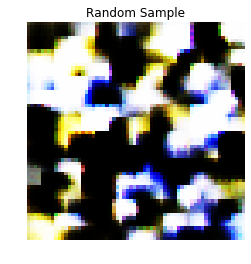

In [16]:
random_codings = tf.random.normal(shape=(1, 8, 8, 64))

random_generated_image = test_random_ae.layers[1](random_codings)

plt.imshow(random_generated_image[0])
plt.title("Random Sample")
plt.axis("off")
plt.show()

# Set Hyperparameters

In [ ]:
pretraining_steps = 10000
training_episodes = 1000000

n_steps = 10
dqn_loss = keras.losses.Huber(reductions=None)
expert_loss_ratio = 0.01
